# Отток клиентов

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Имеются исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## План выполнения работы:
### <a href=#1>1. Подготовка данных</a>
   #### <a href=#a_1> Исследование данных</a>
   #### <a href=#b_1> Замена пропусков</a>
   #### <a href=#c_1> Кодирование категориальных признаков</a>
   #### <a href=#d_1> Приведение количественных признаков к одному масштабу</a>
   #### <a href=#e_1> Подготовка выборки</a>

### <a href=#2>2. Исследование задачи</a>
   #### <a href=#a_2> Найдём соотношение классов в целвом признаке</a>
   #### <a href=#b_2> Обучим модели на несбалансированных данных</a>
### <a href=#3>3. Борьба с дисбалансом</a>
   #### <a href=#a_3> Взвешевание классов</a>
   #### <a href=#b_3> Upsampling (увеличение выборки)</a>
   #### <a href=#c_3> Downsampling (уменьшение выборки)</a>
   #### <a href=#d_3> Подбор гиперпараметров</a>
   #### <a href=#e_3> Обучение модели</a>
### <a href=#4>4. Тестирование модели </a> 
### <a href=#5>5. Вывод </a> 


# <a id='1'> 1. Подготовка данных</a> 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings

### <a id='a_1'> Исследование данных:</a> 

In [2]:
churn = pd.read_csv('\practikum\Churn.csv', index_col='RowNumber')


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


#### Вывод:
В выборке присутствуют
- бинарные признаки в столбцах HasCrCard и IsActiveMember, 
- количественные в столбцах CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary
- категориальные признаки в столбцах Surname, Geography, Gender

Есть пропуски в столбце Tenure (количество недвижимости у клиента)

К категориальным признакам необходимо применить one-hot-encoding

Все количественные признаки необходимо привести к одному масштабу.

### <a id='b_1'> Замена пропусков:</a> 

In [4]:
isna_data = pd.DataFrame(churn.isna().sum())
isna_data.columns = ['nan']
isna_data['rate'] = isna_data['nan']/len(churn)
isna_data.style.format("{:.2%}", subset='rate')

,nan,rate
CustomerId,0,0.00%
Surname,0,0.00%
CreditScore,0,0.00%
Geography,0,0.00%
Gender,0,0.00%
Age,0,0.00%
Tenure,909,9.09%
Balance,0,0.00%
NumOfProducts,0,0.00%
HasCrCard,0,0.00%


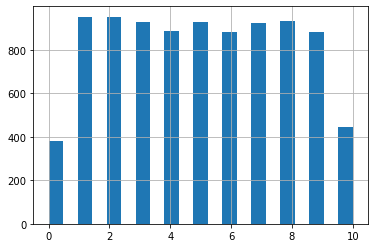

In [5]:
churn['Tenure'].hist(bins = 21)

In [6]:
churn['Tenure'].mode()

0    1.0
dtype: float64

Заменим пропуски на самые часто встречающиеся значения. 

In [7]:
churn['Tenure'] = churn['Tenure'].fillna(1)
churn.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### <a id='c_1'> Кодирование категориальных признаков:</a> 

In [8]:
churn = churn.drop(['Surname','CustomerId'] , axis=1)

In [9]:
categories = ['Geography', 'Gender']
quantity = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [10]:
churn = pd.get_dummies(churn, columns=categories, drop_first=True)

In [11]:
churn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### <a id='e_1'> Подготовка выборки:</a> 

Разделим выборку на матрицу признаков и вектор целевого признака:

In [12]:
features = churn.drop('Exited', axis=1)
target = churn['Exited']

Разделим выборку на обучающую, тестовую и валидационную:

In [13]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=241)
print('Размеры обучающей и валидационной выборки', features_train_valid.shape, target_train_valid.shape)
print('Размеры тестовой выборки', features_test.shape, target_test.shape)

Размеры обучающей и валидационной выборки (8000, 11) (8000,)
Размеры тестовой выборки (2000, 11) (2000,)


In [14]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=241)
print('Размеры обучающей выборки', features_train.shape, target_train.shape)
print('Размеры тестовой выборки', features_valid.shape, target_valid.shape)

Размеры обучающей выборки (6000, 11) (6000,)
Размеры тестовой выборки (2000, 11) (2000,)


### <a id='d_1'> Приведение количественных признаков к одному масштабу: </a> 

In [15]:
pd.options.mode.chained_assignment = None

In [16]:
scaler = StandardScaler().fit(features_train[quantity])
features_train[quantity] = scaler.transform(features_train[quantity])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
583,-0.670249,1.751561,-0.538158,-1.229941,0.803922,0,1,-1.632003,0,1,0
3103,-0.114737,-0.936453,-0.538158,-1.229941,0.803922,1,0,-1.689417,0,0,0
3286,0.862552,0.407554,1.471768,0.346394,-0.908372,0,0,1.460581,1,0,0
1417,-0.680536,-0.552451,1.136781,-1.229941,0.803922,1,0,0.241165,0,1,0
1953,-0.279333,-1.128454,1.471768,0.280343,0.803922,0,1,-1.659501,1,0,1


In [17]:
features_valid[quantity] = scaler.transform(features_valid[quantity])
features_test[quantity] = scaler.transform(features_test[quantity])
features_train_valid[quantity] = scaler.transform(features_train_valid[quantity])

# <a id='2'> 2. Исследование задачи</a> 

### <a id='a_2'> Найдём соотношение классов в целвом признаке:</a> 

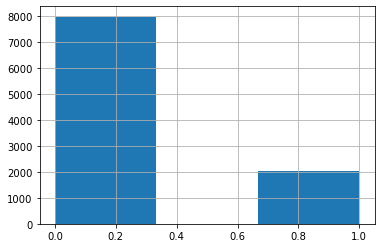

In [18]:
target.hist(bins=3)

In [19]:
print('Доля отрицательного класса "0" = {:.0%}'.format(len(churn.query('Exited==0'))/len(target)))
print('Доля положительного класса "1" = {:.0%}'.format(len(churn.query('Exited!=0'))/len(target)))

Доля отрицательного класса "0" = 80%
Доля положительного класса "1" = 20%


#### В целевом признаке наблюдается дисбаланс классов. 

### <a id='b_2'> Обучим модели на несбалансированных данных:</a> 

In [20]:
def get_f1(model, features_df, target_df):
    prediction = model.predict(features_df)
    f1 = metrics.f1_score(target_df, prediction)
    print('F1 =', f1)
    return f1

In [21]:
def get_auc_score(model, features_df, target_df):
    probabilities_valid = model.predict_proba(features_df)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = metrics.roc_auc_score(target_df, probabilities_one_valid)
    print('AUC-ROC =', auc_roc)
    fpr, tpr, thresholds = metrics.roc_curve(target_df, probabilities_one_valid)
    return fpr, tpr, auc_roc


In [22]:
def get_roc_plot(fpr, tpr, model_lable):
    plt.figure()
    plt.plot(fpr, tpr, label=model_lable)
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right', fancybox=True)
    plt.show()

In [23]:
#соберём значения метрик в массивы для удобства сравнения
unbalanced_f = []
unbalanced_roc_auc = []

In [24]:
print('Оценка качества рещающего дерева на несбалансированных данных')
model_dtc = DecisionTreeClassifier(random_state=241).fit(features_train, target_train)
fpr_dtc_nb, tpr_dtc_nb, auc_roc_dtc_nb = get_auc_score(model_dtc, features_valid, target_valid)
f1_dtc_nb = get_f1(model_dtc, features_valid, target_valid)
unbalanced_f.append(f1_dtc_nb)
unbalanced_roc_auc.append(auc_roc_dtc_nb)

print('Оценка качества случайного леса на несбалансированных данных')
model_rfc = RandomForestClassifier(random_state=241).fit(features_train, target_train)
fpr_rfc_nb, tpr_rfc_nb, auc_roc_rfc_nb = get_auc_score(model_rfc, features_valid, target_valid)
f1_rfc_nb = get_f1(model_rfc, features_valid, target_valid)
unbalanced_f.append(f1_rfc_nb)
unbalanced_roc_auc.append(auc_roc_rfc_nb)

Оценка качества рещающего дерева на несбалансированных данных
AUC-ROC = 0.6851895928022935
F1 = 0.49822904368358917
Оценка качества случайного леса на несбалансированных данных
AUC-ROC = 0.8675466982794527
F1 = 0.5555555555555556


In [25]:
print('Оценка качества логистической регрессии на несбалансированных данных')
model_lr = LogisticRegression(random_state=241,solver='lbfgs').fit(features_train, target_train)
f1_lr_nb = get_f1(model_lr, features_valid, target_valid)
fpr_lr_nb, tpr_lr_nb, auc_roc_lr_nb = get_auc_score(model_lr, features_valid, target_valid)
unbalanced_f.append(f1_lr_nb)
unbalanced_roc_auc.append(auc_roc_lr_nb)

Оценка качества логистической регрессии на несбалансированных данных
F1 = 0.3068783068783069
AUC-ROC = 0.7728792199331432


In [26]:
quality_f = pd.DataFrame(unbalanced_f, columns=['F1_unbalanced'], 
                         index=['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression'])
quality_auc_roc = pd.DataFrame(unbalanced_roc_auc, columns=['AUC-ROC_unbalanced'], 
                         index=['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression'])


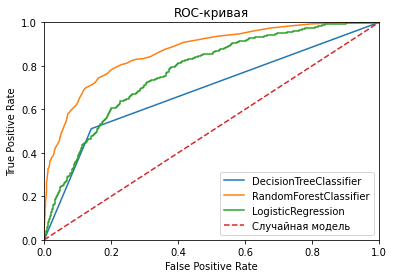

In [27]:
plt.figure()
plt.plot(fpr_dtc_nb, tpr_dtc_nb, label='DecisionTreeClassifier')
plt.plot(fpr_rfc_nb, tpr_rfc_nb, label='RandomForestClassifier')
plt.plot(fpr_lr_nb, tpr_lr_nb, label='LogisticRegression')
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right', fancybox=True)
plt.show()

### Вывод:
В целевом признаке наблюдается дисбаланс классов. 
- Доля отрицательного класса "0" = 80%
- Доля положительного класса "1" = 20%

По значению F1-меры видно что на несбалансированных данные лучше всего случайного леса (0.535). 
По ROC-кривой и из значения площади под ней тоже видно что случайный лес более удачная модель (0.828). Логистическая регрессия по значению f1 проигрывает у дерева, но опережает по значению площади.

# <a id='3'> 3. Борьба с дисбалансом</a> 

### <a id='a_3'> Взвешевание классов:</a> 

Обучим модели с параметром class_weight=“balanced”

In [28]:
balanced_f = []
balanced_roc_auc = []

In [29]:
model_dtc = DecisionTreeClassifier(random_state=241, 
                                   class_weight='balanced').fit(features_train, target_train)
model_rfc = RandomForestClassifier(random_state=241, 
                                   class_weight='balanced').fit(features_train, target_train)
model_lr = LogisticRegression(random_state=241, class_weight='balanced',
                              solver='lbfgs').fit(features_train, target_train)

In [30]:
print('Оценка качества рещающего дерева на сбалансированных данных')
f1_dtc_b = get_f1(model_dtc, features_valid, target_valid)
fpr_dtc_b, tpr_dtc_b, auc_roc_dtc_b = get_auc_score(model_dtc, features_valid, target_valid)
balanced_f.append(f1_dtc_b)
balanced_roc_auc.append(auc_roc_dtc_b)

Оценка качества рещающего дерева на сбалансированных данных
F1 = 0.49204406364749087
AUC-ROC = 0.6793842524995003


In [31]:
print('Оценка качества случайного леса на сбалансированных данных')
f1_rfc_b = get_f1(model_rfc, features_valid, target_valid)
fpr_rfc_b, tpr_rfc_b, auc_roc_rfc_b = get_auc_score(model_rfc, features_valid, target_valid)
balanced_f.append(f1_rfc_b)
balanced_roc_auc.append(auc_roc_rfc_b)

Оценка качества случайного леса на сбалансированных данных
F1 = 0.5381026438569206
AUC-ROC = 0.8624119091101886


In [32]:
print('Оценка качества логистической регрессии на сбалансированных данных')
f1_lr_b = get_f1(model_lr, features_valid, target_valid)
fpr_lr_b, tpr_lr_b, auc_roc_lr_b = get_auc_score(model_lr, features_valid, target_valid)
balanced_f.append(f1_lr_b)
balanced_roc_auc.append(auc_roc_lr_b)

Оценка качества логистической регрессии на сбалансированных данных
F1 = 0.5016556291390729
AUC-ROC = 0.7768933724526303


In [33]:
quality_f['balanced'] = balanced_f
quality_auc_roc['balanced'] = balanced_roc_auc

#### F1-мера увеличилась у всех моделей.

### <a id='b_3'> Upsampling (увеличение выборки)</a> 

Икусственно увеличим количество данных со значением целевой переменной "1" в 4 раза.

In [34]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=241)
    
    return features_upsampled, target_upsampled

In [35]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Обучим на этих данных модели:

In [36]:
upsampling_f = []
upsampling_roc_auc = []

In [37]:
model_dtc = DecisionTreeClassifier(random_state=241).fit(features_upsampled, target_upsampled)
model_rfc = RandomForestClassifier(random_state=241).fit(features_upsampled, target_upsampled)
model_lr = LogisticRegression(random_state=241,
                              solver='lbfgs').fit(features_upsampled, target_upsampled)

In [38]:
print('Оценка качества рещающего дерева на upsample-данных')
f1_dtc_u = get_f1(model_dtc, features_valid, target_valid)
fpr_dtc_u, tpr_dtc_u, auc_roc_dtc_u = get_auc_score(model_dtc, features_valid, target_valid)
upsampling_f.append(f1_dtc_u)
upsampling_roc_auc.append(auc_roc_dtc_u)

print('Оценка качества случайного леса на upsample-данных')
f1_rfc_u = get_f1(model_rfc, features_valid, target_valid)
fpr_rfc_u, tpr_rfc_u, auc_roc_rfc_u = get_auc_score(model_rfc, features_valid, target_valid)
upsampling_f.append(f1_rfc_u)
upsampling_roc_auc.append(auc_roc_rfc_u)

print('Оценка качества логистической регрессии на upsample-данных')
f1_lr_u = get_f1(model_lr, features_valid, target_valid)
fpr_lr_u, tpr_lr_u, auc_roc_lr_u = get_auc_score(model_lr, features_valid, target_valid)
upsampling_f.append(f1_lr_u)
upsampling_roc_auc.append(auc_roc_lr_u)

Оценка качества рещающего дерева на upsample-данных
F1 = 0.48216482164821645
AUC-ROC = 0.6730159238729936
Оценка качества случайного леса на upsample-данных
F1 = 0.5898123324396782
AUC-ROC = 0.8610204582938555
Оценка качества логистической регрессии на upsample-данных
F1 = 0.5012366034624897
AUC-ROC = 0.7769101553023888


In [39]:
quality_f['upsampling'] = upsampling_f
quality_auc_roc['upsampling'] = upsampling_roc_auc

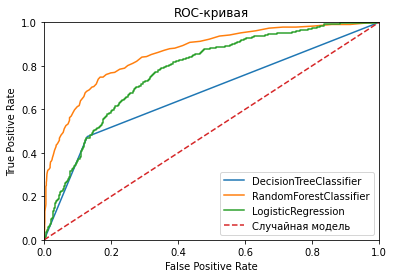

In [40]:
plt.figure()
plt.plot(fpr_dtc_u, tpr_dtc_u, label='DecisionTreeClassifier')
plt.plot(fpr_rfc_u, tpr_rfc_u, label='RandomForestClassifier')
plt.plot(fpr_lr_u, tpr_lr_u, label='LogisticRegression')
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right', fancybox=True)
plt.show()

#### На данных с применением метода Upsampling значения F1-мера изменились на всех моделях.



### <a id='c_3'> Downsampling (уменьшение выборки)</a> 

Уменьшим количество данных со значением целевого признака равным "0".

In [41]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


In [42]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [43]:
downsampling_f = []
downsampling_roc_auc = []

In [44]:
model_dtc = DecisionTreeClassifier(random_state=241).fit(features_downsampled, target_downsampled)
model_rfc = RandomForestClassifier(random_state=241).fit(features_downsampled, target_downsampled)
model_lr = LogisticRegression(random_state=241,
                              solver='lbfgs').fit(features_downsampled, target_downsampled)

In [45]:
print('Оценка качества рещающего дерева на downsample-данных')
fpr_dtc_d, tpr_dtc_d, auc_roc_dtc_d = get_auc_score(model_dtc, features_valid, target_valid)
f1_dtc_d = get_f1(model_dtc, features_valid, target_valid)
downsampling_f.append(f1_dtc_d)
downsampling_roc_auc.append(auc_roc_dtc_d)

print('Оценка качества случайного леса на downsample-данных')
fpr_rfc_d, tpr_rfc_d, auc_roc_rfc_d = get_auc_score(model_rfc, features_valid, target_valid)
f1_rfc_d = get_f1(model_rfc, features_valid, target_valid)
downsampling_f.append(f1_rfc_d)
downsampling_roc_auc.append(auc_roc_rfc_d)

print('Оценка качества логистической регрессии на downsample-данных')
fpr_lr_d, tpr_lr_d, auc_roc_lr_d = get_auc_score(model_lr, features_valid, target_valid)
f1_lr_d = get_f1(model_lr, features_valid, target_valid)
downsampling_f.append(f1_lr_d)
downsampling_roc_auc.append(auc_roc_lr_d)

Оценка качества рещающего дерева на downsample-данных
AUC-ROC = 0.7029122821471673
F1 = 0.4936601859678782
Оценка качества случайного леса на downsample-данных
AUC-ROC = 0.8610410554276499
F1 = 0.603145235892692
Оценка качества логистической регрессии на downsample-данных
AUC-ROC = 0.7751555846458285
F1 = 0.5012165450121654


In [46]:
quality_f['downsampling'] = downsampling_f
quality_auc_roc['downsampling'] = downsampling_roc_auc

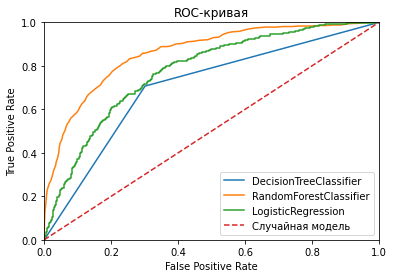

In [47]:
plt.figure()
plt.plot(fpr_dtc_d, tpr_dtc_d, label='DecisionTreeClassifier')
plt.plot(fpr_rfc_d, tpr_rfc_d, label='RandomForestClassifier')
plt.plot(fpr_lr_d, tpr_lr_d, label='LogisticRegression')
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right', fancybox=True)
plt.show()

In [48]:
print('F1-метрика при обучении модели')
quality_f.T

F1-метрика при обучении модели


,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression
F1_unbalanced,0.498229,0.555556,0.306878
balanced,0.492044,0.538103,0.501656
upsampling,0.482165,0.589812,0.501237
downsampling,0.493660,0.603145,0.501217


In [49]:
print('Площадь под ROC-кривой')
quality_auc_roc.T

Площадь под ROC-кривой


,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression
AUC-ROC_unbalanced,0.685190,0.867547,0.772879
balanced,0.679384,0.862412,0.776893
upsampling,0.673016,0.861020,0.776910
downsampling,0.702912,0.861041,0.775156


### Вывод:
#### По данным из сводной таблицы лучшее качество показывает:
- модель RandomForestClassifier на upsampling данных при F1=0.571429 и AUC-ROC=0.833135

Подберём гиперпараметры и обучим модель на всей нашей тренировочной выборке и найдём качество на тестовой части.

### <a id='d_3'>Подбор гиперпараметров</a> 

In [50]:
def get_best_params(features, target, model, parameters):

    #Подберём лучшие параметры модели с помощью RandomizedSearchCV
    clf = RandomizedSearchCV(estimator = model,
                             param_distributions = parameters,
                             scoring='f1', cv = 5,
                             random_state = 124)
    search = clf.fit(features, target)
    print('Best Params: ', search.best_params_)

In [51]:
parameters ={'max_depth':np.arange(1, 20), 
             'n_estimators':np.arange(10, 400, 10), 
             'max_features': ['auto', 'sqrt','log2', None],
             'min_samples_leaf': [4, 6, 8, 12],
             'min_samples_split': [5, 7, 10, 14]}
rand_forest = RandomForestClassifier(random_state=124)
get_best_params(features_upsampled, target_upsampled, 
                rand_forest, parameters)

Best Params:  {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 16}


### <a id='e_3'> Обучение модели</a> 

In [52]:
features_up, target_up = upsample(features_train_valid, target_train_valid, 4)

#### RandomForestClassifier на upsampling данных:

In [53]:
model_rfc = RandomForestClassifier(n_estimators=150, 
                                    min_samples_split=10, 
                                    min_samples_leaf=4, 
                                    max_features='auto', 
                                    max_depth=16, 
                                    random_state=241).fit(features_up, target_up)

# <a id='4'> 4. Тестирование модели</a> 

#### RandomForestClassifier

In [54]:
f1 = get_f1(model_rfc, features_test, target_test)
fpr_rfc, tpr_rfc, auc_roc_rfc = get_auc_score(model_rfc, features_test, target_test)

F1 = 0.5965317919075145
AUC-ROC = 0.8507357096003552


# <a id='5'> 5. Вывод:</a> 


На обучающей выборке по несбалансированным данным модель DecisionTreeClassifier показала большие значения метрик F1 и площади под ROC-кривой по сравнению с upsampling. 
Но по итогам сводной таблицы модель RandomForestClassifier имеет лучшее качество на данных с использованием upsampling-метода баланса данных.